# Simple Contribution Measure Model (Titanic dataset)
This notebook implements a simple contribution model based on the notebook exemple of the DeAI repository. More precisely, it emulates a framework where `num_clients` clients are learning titanic survival prediction and average their models.

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

# Custom functions
from helpers import *

# Reproductibiity
SEED = 123456789
torch.manual_seed(SEED)
np.random.seed(SEED)

# Print option
np.set_printoptions(precision=3, suppress=True)

### Model 
`FC_Net` is strongly inspired by the model found in https://www.kaggle.com/chriszou/titanic-with-pytorch-nn-solution

In [2]:
from models import FC_Net

### Federated Learning Contribution Measure
The following cells implement the case where the central server intitialize the model and the contributions of each user (to zero).

Then, for $t=1,...,r$ with $r=$ `num_rounds`:
1. The central server evaluates the performance of the model on a test datasets (theoretically representing the distribution across users, i.e. the overall tasks),
3. The central server distributes the model to **all** the `num_clients` clients,
4. Each client evaluates the accuracy of the model on its own data (i.e. its own distribution),
5. Each client learns the model on its own data (`epochs` times using batch of size `batch_size`),
6. Each client evaluates the new accuracy of the model on its own data,
7. Each client sends the trained model to the central server,
8. The central server evaluates each client model on its test dataset and compute their accuracy..
9. The central server aggregates the models and update the contributions of each user.



### Data loading and analysis

In [3]:
data_df, test_df_unlab, meta = load_into_df('titanic', drop=['PassengerId', 'Name', 'Ticket', 'Cabin'])

all_df = pd.concat([data_df, test_df_unlab], sort=False)

#fig_all = all_df.hist(color="k", alpha=0.5, bins=20, figsize=(10, 10), layout=(4,2))
#fig_tr = data_df.hist(color="r", alpha=0.5, bins=20, figsize=(10, 10), layout=(4,2))
#fig_te = test_df_unlab.hist(color="b", alpha=0.5, bins=20, figsize=(10, 10), layout=(4,2))

print('Mean of each feature (train):\n{}\n'.format(data_df.mean()))
print('Mean of each feature (unlabelled test):\n{}'.format(test_df_unlab.mean()))

object
object
Mean of each feature (train):
Survived     0.383838
Pclass       1.308642
Sex          0.647587
Age         29.735277
SibSp        0.507295
Parch        0.381594
Fare        32.204208
Embarked     1.538721
dtype: float64

Mean of each feature (unlabelled test):
Survived     0.383838
Pclass       1.265550
Sex          0.636364
Age         30.192052
SibSp        0.437799
Parch        0.382775
Fare        35.621610
Embarked     1.401914
dtype: float64


### Parameters (to be specified)

In [7]:
# Network topology
num_clients = 4
sizes = [0.4, 0.3, 0.2, 0.1]
#comm_matrix = np.ones((num_clients, num_clients)) / num_clients

# Training parameters
num_rounds = 10
epochs = 10
learning_rate = 1e-3
batch_size = 32

# Misc
METRIC = 'loss_norm'
VERBOSE = False

# Model architecture
lin_layer_sizes = [20, 20]
output_size = 2

# Splitting the data into several datasets (train + test)
f_tot = 1
f_test = 0.2
train_ds, test_ds = df_to_datasets(data_df, sizes, meta=meta, label='Survived', f_test=f_test, f_tot=f_tot)

# Creating the dataloaders
train_loaders = ds_to_dataloaders(train_ds, batch_size)
test_loaders = ds_to_dataloaders(test_ds, 10*batch_size)
test_loader_s = ds_to_dataloaders(torch.utils.data.ConcatDataset(test_ds), 10*batch_size)

Sizes:
Full dataset: 891
Reduced dataset: 891
Splitted datasets (total): 890 (train: 714, test: 176)
Per client: [356, 267, 178, 89]


### Marginal loss with Shapley values

In [8]:
from itertools import chain, combinations
from math import factorial

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def coeff_shapley_value(n, s):
    return factorial(n-s) * factorial(s-1) / factorial(n)

def shapley_values(thetas, n, profit=True):
    contributions = np.zeros(n)
    list_coal = list(powerset(range(n)))
    
    for client_id in range(n):
        for coal_id, coal in enumerate(list_coal):
            if client_id in coal:
                coal_minus_client = list(coal)
                coal_minus_client.remove(client_id)
                coal_minus_client_id = list_coal.index(tuple(coal_minus_client))
                if profit:
                    contributions[client_id] += coeff_shapley_value(n, len(coal)) * (thetas[coal_id] - thetas[coal_minus_client_id])
                else:
                    contributions[client_id] += coeff_shapley_value(n, len(coal)) * (thetas[coal_minus_client_id] - thetas[coal_id])
    return contributions

In [9]:
global_model = FC_Net(meta["emb_dims"], meta["n_cont"], lin_layer_sizes, output_size)
marginal_models = [FC_Net(meta["emb_dims"], meta["n_cont"], lin_layer_sizes, output_size) for _ in powerset(range(num_clients))]
num_coal = len(marginal_models)
for model in marginal_models:
        model.load_state_dict(global_model.state_dict())

# performance measures
perf = initialize_perf((num_rounds+1, 1))
perf_pc_s = initialize_perf((num_rounds, num_clients))
perf_pc_prior_tr = initialize_perf((num_rounds, num_clients))
perf_pc_post_tr = initialize_perf((num_rounds, num_clients))
perf_pc_prior_te = initialize_perf((num_rounds, num_clients))
perf_pc_post_te = initialize_perf((num_rounds, num_clients))
marg_perf = initialize_perf((num_rounds, num_coal))


# contribution
contributions = np.zeros((num_rounds, num_clients))

# Untrained performance
fill_perf_history(evaluate_model(global_model, test_loader_s), perf, (0, 0))
print('Prior performance ({}): {:.3f}'.format(METRIC, perf[METRIC][0, 0]))

# Iteration
for r in range(num_rounds):
    if VERBOSE:
        print("------------------------------------\nRound {}:".format(r+1))
    else:
        print("Round {}/{}".format(r+1, num_rounds), end='\r')
        
    # step 1. Evaluating the prior model on the global test dataset
    if r == 0:
        for row in range(num_rounds): 
            fill_perf_history( evaluate_model(global_model, test_loader_s), marg_perf, (row, 0))
    
    # step 2: Sending the model (emulating)
    client_models = [FC_Net(meta["emb_dims"], meta["n_cont"], lin_layer_sizes, output_size) for _ in range(num_clients)]
    for model in client_models:
        model.load_state_dict(global_model.state_dict())


    # step 3. Evaluating the prior model on each local test dataset
    for i in range(num_clients):
        fill_perf_history(evaluate_model(client_models[i], train_loaders[i]), perf_pc_prior_tr, (r, i))
        fill_perf_history(evaluate_model(client_models[i], test_loaders[i]), perf_pc_prior_te, (r, i))

    
    # step 4. Learning on client side
    opt = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]
    loss = 0
    for i in range(num_clients):
        loss += client_update(client_models[i], opt[i], train_loaders[i], epoch=epochs)

    
    # step 5. Evaluating the posterior model on each local test dataset
    for i in range(num_clients):        
        fill_perf_history(evaluate_model(client_models[i], train_loaders[i]), perf_pc_post_tr, (r, i))
        fill_perf_history(evaluate_model(client_models[i], test_loaders[i]), perf_pc_post_te, (r, i))
    
    
    # step 6. Sending the local models to the server (nothing to do)


    # step 7. Evaluating the posterior models on the global test dataset
    for i in range(num_clients):
        fill_perf_history(evaluate_model(client_models[i], test_loader_s), perf_pc_s, (r,  i))
    
    
    # step 8. Aggregating the models
    average_models(global_model, client_models)
    for coal_id, coalition in enumerate(powerset(client_models)):
        if coal_id != 0:
            average_models(marginal_models[coal_id], coalition)
    
    # step 9. Updating the marginal performances and the contributions
    for coal_id in range(1, num_coal):
        fill_perf_history(evaluate_model(marginal_models[coal_id], test_loader_s), marg_perf, (r, coal_id))
    
    fill_perf_history(evaluate_model(global_model, test_loader_s), perf, (r+1, 0))
    contributions[r,:]= shapley_values(marg_perf[METRIC][r, :], num_clients)
    
    if VERBOSE:
        print("Performance: {:.3f} ".format(perf[METRIC][r+1, 0]))
        print("Prior performance on client side: ", perf_pc_prior_te[METRIC][r, :])
        print("Posterior performance on client side: ", perf_pc_post_te[METRIC][r, :])
        print("Posterior performance on server side: ", perf_pc_s[METRIC][r, :])
        print("Total contributions: {}".format(contributions[r, :]))
        print("Cumulative contributions: {}".format(contributions.sum(0)))
    
fill_perf_history(evaluate_model(global_model, test_loader_s), perf,  (-1, 0))
print("------------------------------------\nFinal performance ({}): {:.3f}".format(METRIC, perf[METRIC][-1, 0]))




Prior performance (loss_norm): 4.301
------------------------------------
Final performance (loss_norm): 0.696


### Marginal losses with deletion

In [10]:
def marginal_contribution(perf, marg_perfs, profit=True):
    if profit:
        contributions = perf - marg_perfs
    else:
        contributions = marg_perfs - perf
    return contributions

In [11]:
global_model = FC_Net(meta["emb_dims"], meta["n_cont"], lin_layer_sizes, output_size)
marginal_models = [FC_Net(meta["emb_dims"], meta["n_cont"], lin_layer_sizes, output_size) for _ in range(num_clients)]
for model in marginal_models:
        model.load_state_dict(global_model.state_dict())

# performance measures
perf = initialize_perf((num_rounds+1, 1)) # perf[0] contains the performance prior to learning
perf_pc_s = initialize_perf((num_rounds, num_clients))
perf_pc_prior_tr = initialize_perf((num_rounds, num_clients))
perf_pc_post_tr = initialize_perf((num_rounds, num_clients))
perf_pc_prior_te = initialize_perf((num_rounds, num_clients))
perf_pc_post_te = initialize_perf((num_rounds, num_clients))
marg_perf = initialize_perf((num_rounds, num_clients))


# contribution
contributions = np.zeros((num_rounds, num_clients))

# Untrained performance
fill_perf_history(evaluate_model(global_model, test_loader_s), perf, (0, 0))
print('Prior performance ({}): {:.3f}'.format(METRIC, perf[METRIC][0, 0]))

# Iteration
for r in range(num_rounds):
    if VERBOSE:
        print("------------------------------------\nRound {}:".format(r+1))
    else:
        print("Round {}/{}".format(r+1, num_rounds), end='\r')
        
    # step 1. Evaluating the prior model on the global test dataset
    #fill_perf_history(evaluate_model(global_model, test_loader_s), perf, (r, 0))
    
    # step 2: Sending the model (emulating)
    client_models = [FC_Net(meta["emb_dims"], meta["n_cont"], lin_layer_sizes, output_size) for _ in range(num_clients)]
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

    # step 3. Evaluating the prior model on each local test dataset
    for i in range(num_clients):
        fill_perf_history(evaluate_model(client_models[i], train_loaders[i]), perf_pc_prior_tr, (r, i))
        fill_perf_history(evaluate_model(client_models[i], test_loaders[i]), perf_pc_prior_te, (r, i))
    
    # step 4. Learning on client side
    opt = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]
    loss = 0
    for i in range(num_clients):
        loss += client_update(client_models[i], opt[i], train_loaders[i], epoch=epochs)

    # step 5. Evaluating the posterior model on each local test dataset
    for i in range(num_clients):        
        fill_perf_history(evaluate_model(client_models[i], train_loaders[i]), perf_pc_post_tr, (r, i))
        fill_perf_history(evaluate_model(client_models[i], test_loaders[i]), perf_pc_post_te, (r, i))
    
    # step 6. Sending the local models to the server (nothing to do)

    # step 7. Evaluating the posterior clients models on the global test dataset
    for i in range(num_clients):
        fill_perf_history(evaluate_model(client_models[i], test_loader_s), perf_pc_s, (r,  i))
    
    # step 8. Aggregating the models
    average_models(global_model, client_models)
    for i in range(num_clients):
        average_models(marginal_models[i], client_models[:i] + client_models[i+1:])
    
    # step 9. Updating the marginal performances and the contributions
    for i in range(num_clients):
        fill_perf_history(evaluate_model(marginal_models[i], test_loader_s), marg_perf, (r, i))
    
    fill_perf_history(evaluate_model(global_model, test_loader_s), perf,  (r + 1, 0))
    contributions[r,:]= marginal_contribution(perf[METRIC][r+1], marg_perf[METRIC][r, :], profit=True)
    
    if VERBOSE:
        print("Performance: {:.3f} ".format(perf[METRIC][r+1, 0]))
        print("Prior performance on client side: ", perf_pc_prior_te[METRIC][r, :])
        print("Posterior performance on client side: ", perf_pc_post_te[METRIC][r, :])
        print("Posterior performance on server side: ", perf_pc_s[METRIC][r, :])
        print("Total contributions: {}".format(contributions[r, :]))
        print("Cumulative contributions: {}".format(contributions.sum(0)))
    
fill_perf_history(evaluate_model(global_model, test_loader_s), perf,  (-1, 0))
print("------------------------------------\nFinal performance ({}): {:.3f}".format(METRIC, perf[METRIC][-1, 0]))


Prior performance (loss_norm): 9.484
------------------------------------
Final performance (loss_norm): 0.679


### Training history vizualization

In [12]:
from visualization import visualization

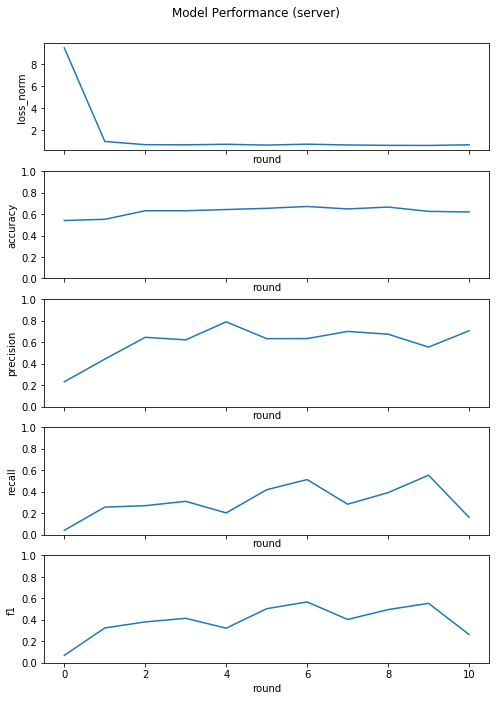

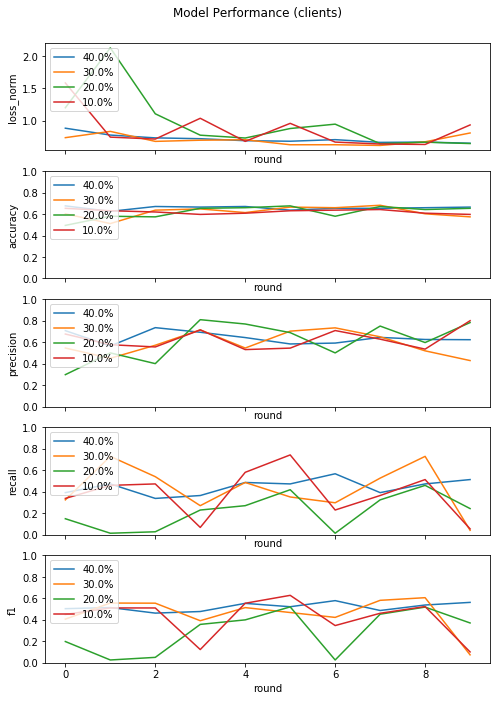

In [14]:
# Model performance
visualization(perf, suptitle='Model Performance (server)')

# Clients performance
visualization(perf_pc_s, suptitle='Model Performance (clients)', legends=sizes)

# Prior training loss
#visualization(perf_pc_prior_tr, suptitle='Train Performance (prior)', legends=sizes)

# Prior testing loss
#visualization(perf_pc_prior_te, suptitle='Test Performance (prior)', legends=sizes)

# Posterior training loss
#visualization(perf_pc_post_tr, suptitle='Train Performance (posterior)', legends=sizes)

# Posterior testing loss
#visualization(perf_pc_post_te, suptitle='Test Performance (posterior)', legends=sizes)